# OFFENSIVE LANGUAGE DETECTION

## Business Use Case

A company, that has a blog for employees, wants to develop a model for detecting offensiv language so that it can prevent employees from posting such.

## Hypothesis & Objectives

The hypothesis is that we can enable software to automatically detect offensive posts by training a model with text data (tweets) that have been labelled.

The objective of this Project is to:
1. Obtain labelled (Offensive & Non offensive) Textual data
2. Preprocess the textual data
3. Extract features from the data
4. Handle imbalance in the dataset
5. Implement different models to classify the employees' posts
6. Evaluate the perormance of the different classification models & feature extraction techniques
7. Make recommendation to the company (What model is best suited for their business need?)
8. Deploy the model 

## Importing Libraries

In [1]:
#!pip install -U pip setuptools wheel --user
#!pip install -U spacy --user

In [2]:
#!python -m spacy download en_core_web_md 

In [3]:
#pip install contractions

In [4]:
#pip install emoji

In [5]:
#pip install word2number

In [6]:
# pip install wordcloud

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
import spacy
import contractions
import emoji
import string
from word2number import w2n
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import logging
import numpy as np
import gensim.downloader as api
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

In [8]:

# !pip install transformers 

In [9]:
# %conda install -c pytorch pytorch torchvision

#I had to use the % to make sure pytorch was being installed in the same environment I have my notebook running, before this I was getting 'no module found" error'

In [10]:
import torch
from transformers import AutoTokenizer, AutoModel

#### Download some components from nltk

In [11]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Data

I obtained the Offensive Language Identification Dataset - OLID from https://scholar.harvard.edu/malmasi/olid

The dataset contains annotated tweets with 3 levels. 
 - The first level denotes whether the tweet is offensive (OFF) or not (NOT). 
 - The second level denotes the type of the offensive tweet and could be targeted insult (TIN) or un-targeted (UNT).
 - The third level denotes the target of the offensive post categorized mainly into individual (IND), group (GRP) or other (OTH).

## Part 1 - Data Exploration

## Load Data

In [12]:
df = pd.read_table(r'C:\Users\ASUS\Offensive_Language_Detection\olid.txt')
df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


## Data Exploration

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


There are 5 columns in the dataset. Now are all these columns relevant to our objective?

Since the objective is to detect offensive language and I am not trying to do any additional analysis for now, I do not need subtask_b and subtask_c.
Also, the id of the tweet does not have any effect on the nature (offensive or not) of the tweet.
So the only columns that are relevant to the objective are 'tweet' & 'subtask_a'

### Drop unwanted columns

In [14]:
df.drop(labels=['id', 'subtask_b', 'subtask_c'], axis = 1, inplace=True)
df

,tweet,subtask_a
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT
...,...,...
13235,@USER Sometimes I get strong vibes from people...,OFF
13236,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT
13237,@USER And why report this garbage. We don't g...,OFF
13238,@USER Pussy,OFF


### Check for missing values

In [15]:
#check for null values 
df.isnull().sum()

tweet        0
subtask_a    0
dtype: int64

Looks like there are no missing values in the dataset

### Rename column

To make it easier to refer to the label, I'll rename the second column from subtask_a to 'label'

In [16]:
df.rename(mapper = {'subtask_a':'label'}, inplace=True, axis = 1)
df

,tweet,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT
...,...,...
13235,@USER Sometimes I get strong vibes from people...,OFF
13236,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT
13237,@USER And why report this garbage. We don't g...,OFF
13238,@USER Pussy,OFF


### Check the distribution of the observations i.e the proportion of offensive and and Not offensive 

In [17]:
df['label'].value_counts(normalize = True)* 100

NOT    66.767372
OFF    33.232628
Name: label, dtype: float64

<AxesSubplot:title={'center':'Label distribution'}, xlabel='Label', ylabel='No of Observations'>

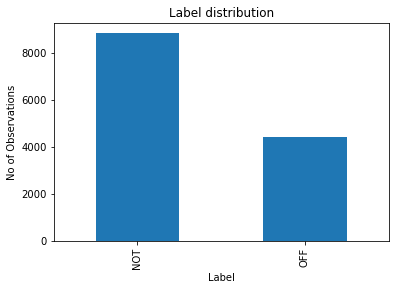

In [18]:
df['label'].value_counts().plot(kind='bar', title='Label distribution' , xlabel='Label', ylabel='No of Observations')

The no of observations labelled as offensive is significantly lower than and is actually less than half of the no of observations labeled as not offensive.

Hence, this data set is imbalanced.

To prevent our model from being biased towards the majority class and to ensure the model is able to accurately predict both the minority and majority classes, we need to deal with this imbalance

### Label Encoding

Because some models expect numeric values for the labels, I will replace **'OFF' with 1** and **'NOT' with 0** 

In [19]:
df['label'] = df['label'].replace(['OFF', 'NOT'], [1, 0])
df['label'].value_counts(normalize = True)* 100

0    66.767372
1    33.232628
Name: label, dtype: float64

### Check the text data

Lets take a look at the nature of the data

In [20]:
for tweet in df['tweet'][:10]:
    print(tweet)

@USER She should ask a few native Americans what their take on this is.
@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL
Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT
@USER Someone should'veTaken" this piece of shit to a volcano. 😂"
@USER @USER Obama wanted liberals &amp; illegals to move into red states
@USER Liberals are all Kookoo !!!
@USER @USER Oh noes! Tough shit.
@USER was literally just talking about this lol all mass shootings like that have been set ups. it’s propaganda used to divide us on major issues like gun control and terrorism
@USER Buy more icecream!!!
@USER Canada doesn’t need another CUCK! We already have enough #LooneyLeft #Liberals f**king up our great country! #Qproofs #TrudeauMustGo


In [21]:
#for tweet in df['tweet'][2000:2020]:
#    print(tweet)

Looking at the few tweets printed, I can observe the following:
1. There are punctuations like "",!# etc
2. Some tweets have emojis
3. Some tweets originally had urls which have been replaced by "URL"
4. Some tweets have numbers either in numeric form like 6 or in words like "three"
5. Some words have been abbrevited like "w/", 2nd etc.
6. There are some contracted words like dont, couldnt etc
7. There are a variety of uppercase, lowercase and capitalized words
8. @USER is present in most tweets, representing profiles tagged in the tweets

Most of the observations above are not helpful as they do not  have anything to do whether the tweet is offensive or not. 

So, in this case they can be regarded as noise. To improve the chances of getting good results with this model, I need to clean the data and remove these things.

## Part 2 - Text Preprocessing

### Expanding Contractions

As observed, some of the tweets contain contractions like don't, it's etc.
If I tokenize the text with these contractions, most of these words would lose their meaning, don't will turn to do & n't which doesn't really make any sense.
So before tokenizing, I will expand these contracted words

In [22]:
df['tweet'] = df['tweet'].apply(contractions.fix)
#for tweet in df['tweet'][:20]:
#    print(tweet)

### Normalization
Need to convert all the text to lower case

In [23]:
#create a function that will convert the text to lower case
def lowercase(word):
    return word.lower()

In [24]:
#apply the function
df['tweet'] = df['tweet'].apply(lowercase)
for tweet in df['tweet'][:5]:
    print(tweet)

@user she should ask a few native americans what their take on this is.
@user @user go home you are drunk!!! @user #maga #trump2020 👊🇺🇸👊 url
amazon is investigating chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. url #amazon #maga #kag #china #tcot
@user someone should'vetaken" this piece of shit to a volcano. 😂"
@user @user obama wanted liberals &amp; illegals to move into red states


### Remove Emoji

In [25]:
#create a function to remove emojis 

def remove_emoji(text):
    return emoji.replace_emoji(text,replace='')

In [26]:
#apply the function
df['tweet'] = df['tweet'].apply(remove_emoji)
for tweet in df['tweet'][:6]:
    print(tweet)

@user she should ask a few native americans what their take on this is.
@user @user go home you are drunk!!! @user #maga #trump2020  url
amazon is investigating chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. url #amazon #maga #kag #china #tcot
@user someone should'vetaken" this piece of shit to a volcano. "
@user @user obama wanted liberals &amp; illegals to move into red states
@user liberals are all kookoo !!!


### Remove Punctuation marks 

In [27]:
punctuation_marks = string.punctuation
#create a function to remove punctuation marks
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation_marks))

In [28]:
#apply the function
df['tweet'] = df['tweet'].apply(remove_punctuation)
for tweet in df['tweet'][:6]:
    print(tweet)

user she should ask a few native americans what their take on this is
user user go home you are drunk user maga trump2020  url
amazon is investigating chinese employees who are selling internal data to thirdparty sellers looking for an edge in the competitive marketplace url amazon maga kag china tcot
user someone shouldvetaken this piece of shit to a volcano 
user user obama wanted liberals amp illegals to move into red states
user liberals are all kookoo 


### Remove 'user' & 'url'

Most of the tweets contain the words 'user' & 'url' which represent other profiles being tagged and web links. As these re not useful to the classification, we need to remove them too

In [29]:
#create function emove url & user
def remove_url_user(text):
    text_1 = text.replace('url','')
    return text_1.replace('user', '')

In [30]:
#apply the function 
df['tweet'] = df['tweet'].apply(remove_url_user)

### Tokenization

Now we can split the text into words

In [31]:
df['tweet'] = df['tweet'].apply(word_tokenize)


In [32]:
for tweet in df['tweet'][:8]:
    print(tweet)

['she', 'should', 'ask', 'a', 'few', 'native', 'americans', 'what', 'their', 'take', 'on', 'this', 'is']
['go', 'home', 'you', 'are', 'drunk', 'maga', 'trump2020']
['amazon', 'is', 'investigating', 'chinese', 'employees', 'who', 'are', 'selling', 'internal', 'data', 'to', 'thirdparty', 'sellers', 'looking', 'for', 'an', 'edge', 'in', 'the', 'competitive', 'marketplace', 'amazon', 'maga', 'kag', 'china', 'tcot']
['someone', 'shouldvetaken', 'this', 'piece', 'of', 'shit', 'to', 'a', 'volcano']
['obama', 'wanted', 'liberals', 'amp', 'illegals', 'to', 'move', 'into', 'red', 'states']
['liberals', 'are', 'all', 'kookoo']
['oh', 'noes', 'tough', 'shit']
['was', 'literally', 'just', 'talking', 'about', 'this', 'lol', 'all', 'mass', 'shootings', 'like', 'that', 'have', 'been', 'set', 'ups', 'it', 'is', 'propaganda', 'used', 'to', 'divide', 'us', 'on', 'major', 'issues', 'like', 'gun', 'control', 'and', 'terrorism']


### Remove numbers

Some of the text contains numbers, both in numeric & word format. These numbers would most likely have no effect on the classification, so its better to remove them.

To remove numbers, we need to;
1. convert word numbers to digits
2. remove all the numbers

In [33]:
#convert word to numbers
#nltk_pos_tag for some reason tags certain words as CD e.g girl, so I have to use a tray & except block to handle this 

def convert_to_numeric(lists):
    length = len(lists)
    tags = nltk.pos_tag(lists)
    new_list = []
    for i in range(length):
        if tags[i][1] == 'CD':
            try:
                new_list.append(w2n.word_to_num(lists[i]))
            except:
                new_list.append(lists[i])
        else:
            new_list.append(lists[i])
    return new_list


### Convert numbers in words to numbers

In [34]:
df['tweet'] = df['tweet'].apply(convert_to_numeric)

### Remove all numbers

In [35]:
def remove_numbers(lists):
    new_list = []
    for val in lists:
        if not bool(re.search(r'\d', str(val))):
            new_list.append(val)
    return new_list
     


In [36]:
df['tweet'] = df['tweet'].apply(remove_numbers)

### Remove stop words

Stop words are very common words like 'the' and 'are' that would most likely not be of benefit to the classification task. 

For example, having the word "the" in a tweet has nothing to do with the tweet being offensive or not.

So, to save computing time and reduce the volume of text that we have to deal with,it's better to remove these words.

The spacy library has a list of stop words which I can use, but I may have to modify this list and remove certain words which might be relevant to our task.

In [37]:
en = spacy.load('en_core_web_md')
stopwords = en.Defaults.stop_words
print(stopwords)

{'doing', 'also', 'ours', 'eight', 'sometime', 'themselves', 'mostly', 'quite', 'very', 'once', 'of', 'anyone', 'due', 'per', 'less', 'three', 'within', 'n’t', 'becomes', 'nobody', 'too', 're', 'name', 'everyone', 'own', 'made', 'wherein', '’ve', 'thereby', 'used', 'in', 'somewhere', 'except', '’d', 'together', 'hers', 'meanwhile', 'almost', "'ve", 'at', 'many', 'all', 'himself', 'as', 'if', 'never', '‘d', 'are', 'they', 'again', 'somehow', 'beside', 'everything', 'latter', 'six', 'latterly', 'ourselves', 'out', 'rather', 'every', 'none', 'could', 'using', 'so', 'about', 'since', 'whither', 'everywhere', 'otherwise', 'please', 'herein', 'noone', 'not', 'only', 'and', 'often', 'show', 'seeming', 'fifty', 'that', 'alone', 'do', 'enough', 'eleven', 'through', 'it', 'hereby', 'why', 'which', 'these', 'being', 'ten', 'yourselves', 'therefore', 'thereupon', 'down', 'thru', 'here', 'unless', 'this', 'well', 'regarding', 'anyway', 'without', 'whether', 'least', 'below', 'him', 'make', 'sixty',

After carefully observing these stop words, none of them are offensive. Some are ngative like not, n't but they wont have any effect on this offensive classification, so I can remove all of them

In [38]:
def remove_stop_words(lists):
    new_list = []
    for word in lists:
        if word not in stopwords:
            new_list.append(word)
    return new_list

In [39]:
df['tweet'] = df['tweet'].apply(remove_stop_words)

In [40]:
df['tweet'].head(8)

0                             [ask, native, americans]
1                                  [home, drunk, maga]
2    [amazon, investigating, chinese, employees, se...
3                [shouldvetaken, piece, shit, volcano]
4    [obama, wanted, liberals, amp, illegals, red, ...
5                                   [liberals, kookoo]
6                              [oh, noes, tough, shit]
7    [literally, talking, lol, mass, shootings, lik...
Name: tweet, dtype: object

### Lemmatization

The last step in the preprocessing stage is lemmatization. 

Lemmatization is used to convert words into their root form without losing their meaning (this is the advantage lemmatization has over stemming)

In [41]:
def lemmatize_words(lists):
    lemmatizer = WordNetLemmatizer()
    new_list = []
    for word in lists:
        new_list.append(lemmatizer.lemmatize(word))
    return new_list

df['tweet'] = df['tweet'].apply(lemmatize_words)

In [42]:
df['tweet'].head(8)

0                              [ask, native, american]
1                                  [home, drunk, maga]
2    [amazon, investigating, chinese, employee, sel...
3                [shouldvetaken, piece, shit, volcano]
4    [obama, wanted, liberal, amp, illegals, red, s...
5                                    [liberal, kookoo]
6                                [oh, no, tough, shit]
7    [literally, talking, lol, mass, shooting, like...
Name: tweet, dtype: object

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   13240 non-null  object
 1   label   13240 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 207.0+ KB


**Note: There was no extra step for removing white space because the tokenization step already took care of this**

### Visualize the words 

#### To generate the word cloud, I have to combine the already tokenized word into sentences 

In [53]:
#1.Combine the words in each row into a sentence
df_copy = df.copy()
df_copy['tweet'] = df_copy['tweet'].apply(lambda x: " ".join(x))
df_copy['tweet'].head()

0                                  ask native american
1                                      home drunk maga
2    amazon investigating chinese employee selling ...
3                     shouldvetaken piece shit volcano
4          obama wanted liberal amp illegals red state
Name: tweet, dtype: object

In [54]:
df_copy

,tweet,label
0,ask native american,1
1,home drunk maga,1
2,amazon investigating chinese employee selling ...,0
3,shouldvetaken piece shit volcano,1
4,obama wanted liberal amp illegals red state,0
...,...,...
13235,strong vibe people man ’ s vibe ten million mu...,1
13236,benidorm creamfields maga shabby summer,0
13237,report garbage crap,1
13238,pussy,1


In [55]:

df_copy.head()

,tweet,label
0,ask native american,1
1,home drunk maga,1
2,amazon investigating chinese employee selling ...,0
3,shouldvetaken piece shit volcano,1
4,obama wanted liberal amp illegals red state,0


In [56]:
df_copy = df_copy[df_copy['tweet'] != '']
df_copy

,tweet,label
0,ask native american,1
1,home drunk maga,1
2,amazon investigating chinese employee selling ...,0
3,shouldvetaken piece shit volcano,1
4,obama wanted liberal amp illegals red state,0
...,...,...
13235,strong vibe people man ’ s vibe ten million mu...,1
13236,benidorm creamfields maga shabby summer,0
13237,report garbage crap,1
13238,pussy,1


In [ ]:
#2. Split dataset into offensive & Non offensive
df_copy_off = df_copy[df_copy['label'] == 1]['tweet']
df_copy_not = df_copy[df_copy['label'] == 0]['tweet']

In [ ]:
#3 combine all the sentences in each categray (offensive & not offensive) into one sentence
offensive_sent = ''
normal_sent = ''

for row in df_copy_off:
    offensive_sent = offensive_sent + ' ' + row

for row in df_copy_not:
    normal_sent = normal_sent + ' ' + row

In [ ]:
wordcloud1 = WordCloud(background_color="white", max_words=300, contour_width=3,contour_color='steelblue', width=700, height=500, scale=1, max_font_size=500, collocations=False)
wordcloud2 = WordCloud(background_color="white", max_words=300, contour_width=3,contour_color='steelblue', width=700, height=500, scale=1, max_font_size=500, collocations=False)

In [ ]:
#generate wordcloud for the two categories
cloud_offensive = wordcloud1.generate(offensive_sent)
cloud_normal = wordcloud2.generate(normal_sent)

In [ ]:
plt.figure( figsize=(20,10))

plt.subplot(1, 2, 1)
plt.title('300 Most Common Words in Offensive Tweets')
plt.imshow(cloud_offensive)

plt.subplot(1, 2, 2)
plt.title('300 Most Common Words in Non-offensive Tweets')
plt.imshow(cloud_normal)

plt.show()

#### Observation

- Both categories have common words like 'control', 'people', 'trump'
- offensive words like 'shit', 'bitch' can also be seen in the offensve categories

### Limitations of the Preprocessing pipeline

1. The preprocesing does not handle weird symbols tha are not from the english alphabet
2. Does not handle misspelled words
3. Does not remove repetitive words like 'aaaaaaaaa' 'bbbb'

## Part 2 - Feature Extraction

To go further in this classification task, we need to extract features and get the numerical representation of the twitter text so that it can be used by the ML & DL algorithms.
To do this, we will try a number of feature extraction techniques:
1. Bag of words
2. Tf-Idf
3. Word2vec
4. Glove
5. BERT

Since SKlearn's BOW & Tfidf functions expect strings & not list, I will use the dataset with the joined words which I created in the visuaization above.

### Feature Extraction with Bag of Words

#### A few notes on the Bag of Words technique 

- All the unique words in the dataset are collected and become the attributes
- That is, if there are 3000 unique words in the dataset, there will be 3000 columns 
- the values in the column for each row is the frequency of the corresponding word in that row

**Limitations**
- This technique results in a very sparse matrix
- Lots of data to process, thus requiring a lot of computing time and resources
- Gives more weight/importance to words that are frequently occuring but may not actually have any effect on the tweet being negative e.g the word 'right' occured very frequently in offensive tweets
- Will not be able to handle a negative word that was not in the dataset and will actually not be able to correctly classify such a sentence 

In [ ]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(df_copy['tweet'])
counts=pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names())
df_bow = pd.merge(df_copy,counts,left_index =True, right_index=True)


In [ ]:
df_bow.rename({'tweet_x':'tweet','label_x':'label'}, inplace=True, axis = 1)

In [ ]:
df_bow.head()

### Feature Extraction with -Tf-Idf

#### A few notes on the Tf-Idf technique 

- All the unique words in the dataset are collected and become the attributes
- That is, if there are 3000 unique words in the dataset, there will be 3000 columns 
- the values in the column for each row is the frequency of the corresponding word in that row (Term frequency) divided by the total occurences of the word in the whole dataset (Document frequency)

**Advantages over BOW**
- Because it uses TF/DF, it eliminates the issue of giving high important to irrelavnt frequently occuring words. Because words that occur frequently will ave a high document freq (DF) and will thus be assigned a low weight while rare words will have low DF and will be assigned higher weights

**Limitations**
- Also results in a very sparse matrix
- Lots of data to process, thus requiring a lot of computing time and resources
- Will not be able to handle a negative word that was not in the dataset and will actually not be able to correctly classify such a sentence 

In [ ]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf = tfidf_transformer.fit_transform(bow)
tf_idf_counts = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
df_tfidf = pd.merge(df_copy,tf_idf_counts,left_index =True, right_index=True)


In [ ]:
df_tfidf.rename({'tweet_x':'tweet','label_x':'label'}, inplace=True, axis = 1)

### Feature Extraction with Word2Vec

#### A few notes on the Word2Vec technique 

- This technique involves training a feed forward neural network with a single hidden layer to generate n dim vector representations for words.
- There are 2 methods for training the neural network: Continous BOW & Skip gram
  1. In the continous BOW, the surrounding words are used to predict the target/centre words. 
    - e.g We have a sentence: I'm going to the mall to get clothes
    - The target word is mall, we select a window of 3 (this means that we will use the 3 words on each side of the target word to try and predict the target word.
    - so the input to the neural network will be going, to, the, to , get clothes and the netwrok will keep training and updating the weights till it can correctly predict the target word,
    - After training, the weights in the hidden layer will be retrieved as the n dim vector to represent the target word.
    - so if there are 100 units in that layer, our word will be represented by an 100dim vector
  2. In the skipgram model, the target word is used t predict the surrounding words
    - so the input is the target word and the outputs will the 3 surrounding words on either side.

**Advantages over BOW & Tf-Idf**
 - Eliminates the issue of having a sparse matrix and reduces the amount of data that needs to be processed
 - Now that we are no longer dealing with term frequency, it elimintaes the problem f just classifying based on term frequency
 - since words now have vector representations, the model will be able to detect synonyms of different negative words using cosine similarity

**Limitations**
- The word embeddings is only as good as the data used to train it. A good word2vec model needs to be trained with very huge volumes of high quality data like the google word2vec model
- Word2vec only considers the surrounding words in a sentence( based on the window selected) and not the other sentences 

I will train a word2vec model that can be used to feed our ML algorithms. 
To train the word2vec model we need to split the data into train & test

In [ ]:
train_set = df.sample(frac=0.90, random_state = 5)
train_set

In [ ]:
test_set = df.drop(index = train_set.index)
test_set

In [ ]:
train_set.reset_index(inplace=True, drop=True)

In [ ]:
test_set.reset_index(inplace=True, drop=True)

I will train the word2vec model from the genism library 

In [ ]:
#cnvert the tweet column to a list o lists
train_list =  train_set['tweet'].values.tolist()

In [ ]:
#train the word2vec model
w2v_model = Word2Vec(train_list, vector_size=150, window=5, min_count=2, workers=3)
w2v_model.train(train_list,total_examples=11916,epochs=10)

Now lets test our word embeddings

In [ ]:
w1 = "fucking"
w2v_model.wv.most_similar (positive=w1)

In the cell above, I tried to get the words similar to fucking, and words like play,saturday etc are similar based on the embeddings.
This makes me conclude that the word2vec model has not been trained well because we dont have enough data

I can use Google's pretrained word2vec model instead

In [ ]:
# Logging code taken from http://rare-technologies.com/word2vec-tutorial/
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
#Load pretrained glove model
word2vec_model = api.load('word2vec-google-news-300')

Now lets check out the performance of the pre trained model

In [ ]:
w1 = "fucking"
word2vec_model.most_similar (positive=w1)

Now I can see that google's pretrained model is able to get the words that are similar to target words. Because this works better, I will use this model.

#### Create aggregated sentence vectors

Using the google word2vec model, I will create aggregated sentence vectors based on the word vectors for each word in the sentence

In [ ]:
#create a dict of all the words in the word2vec model
words = set(word2vec_model.index_to_key )

In [ ]:
df_vect = np.array([np.array([word2vec_model[word] for word in row if word in words]) for row in df['tweet']])

In [ ]:
df_vect.shape

In [ ]:
df_vect[:5]

Taking a look at our sentence vector, I can see that its an array of arrays (just like a list of lists)
The first array contains 3 arrays which is no surprise, because if we recall, the first sentence is our processed dataset has 3 words. So each of the 3 arrays we see, represents the 300dim for each word in the sentence. 
This means that the dimension of each main array would be different.

If we take a look at the next main array, it also has 3 arrays. Why is this so, since our second sentence has 4 words?
Taking a look at the 2nd sentence, the last word (Trump2020) is most likely not in google trained word 2vec.

Let's test this hypothesis below

In [ ]:
'trump2020' in words

So, as suspected that word isnt in the pretrained model. 

Now lets observe the vectors for the first 20 sentences

In [ ]:
for i, v in enumerate(df_vect[:20]):
    print(len(df['tweet'].iloc[i]), len(v))

**There is an issue here**

There is no consistency in each sentence vector. The first sentence has 3 features. The next one is also 3. But then the next is 17 and then its back to three and then seven... So if we tried to pass this into a machine learning model, it would throw an error because the ML model expects consistency.

To solve this issue I'm going to take an element wide average for each sentence array

In [ ]:
df_vect_avg = []

for array in df_vect:
    if array.size:
        df_vect_avg.append(array.mean(axis=0))
    else:
        df_vect_avg.append(np.zeros(300, dtype=float)) #it is possible that some sentences do not contain any words that have word vectors

Now lets check if the length of our sentence vectors are consistent now

In [ ]:
for i, v in enumerate(df_vect_avg):
    print(len(df['tweet'].iloc[i]), len(v))

Now we can see that all the sentences hava a consistent array size of 300. It is 300 because the google trained word2vec model has 300 dimensions of word embeddings for each word

In [ ]:
#### Create dataframe for word2vec embeddings

In [ ]:
df_w2v = pd.DataFrame(df_vect_avg)
df_w2v

Now we have a numerical featues for our data, 300 columns which represens the embedding vectors or each sentence, this is better (in terms of computing time & resources) than the BOW & TF-IDF models that had about 18,000 columns 

Lets create a full dataset for our word2vec features

In [ ]:
word2vec_df = pd.merge(df[['tweet','label']],df_w2v,left_index =True, right_index=True)
word2vec_df

### Feature Extraction with Glove

#### A few notes on the Glove technique 

- This technique considers the context of words globally (i.e in the whole document or training data) as opposed to only local surrounding words like in the word2vec model.
- In this technique, a word by context matrix is generated such that each distinct word is a row in the matrix and the columns represent different contexts.
- For each word, the frequency of occurence of this word in some “context” (the columns) in the whole training data is counted
- After this, the word-context matrix is factorized to obtain the word - features matrix. 
- In the word - features matix, Each row is now the n-dim vector of each word.


**Advantages over BOW & Tf-Idf**
 - Eliminates the issue of having a sparse matrix and reduces the amount of data that needs to be processed
 - Now that we are no longer dealing with term frequency, it elimintaes the problem f just classifying based on term frequency
 - since words now have vector representations, the model will be able to detect synonyms of different negative words using cosine similarity

**Advantages over Word2vec**
- It considers the context of each word globally and not just in the local surrounding.

**Limitations**
- The word embeddings is only as good as the data used to train it. 
- The words have the same embeddings irrespectve of the context they are used in. ELMO tries to eliminate this issue by looking at sentence before assigning an embedding based on the context the word is used in.


In [ ]:
#Load pretrained glove model
glove_model = api.load('glove-twitter-100')

Lets check out some words & their similarities

In [ ]:
glove_model['boy'], glove_model['boy'].shape

so each word is repesented by a 100 dim vector

In [ ]:
glove_model.most_similar(positive='boy')

As we can see, the model does a pretty good job of fetching other words that are similar to 'boy'

#### Visualize some word vectors

In [ ]:
vocab = ["boy", "girl", "man", "woman", "king", "queen", "banana", "apple", "learn", "study"]

def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model[word])
        labels.append(word)
    
    # n_components: #dimensions to reduce the data into
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(wordvecs)

    #Use Matplotlib Scatter plot
    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(glove_model)

The word vectors for boy,man and girl & woman are quite close but not as close as earn & study because these 2 words practically mean the same thing.  
I will use this model to generate sentence embeddings for my dataset

In [ ]:
#create a set for all unique words in the glove model
glove_words = set(glove_model.index_to_key )
len(glove_words)

so, there are 400000 unique words in the glove model

In [ ]:
df_glove = np.array([np.array([glove_model[word] for word in row if word in glove_words]) for row in df['tweet']])
df_glove.shape

In [ ]:
#Lets take a look into this matrix
df_glove[:5]

This is similar to what was observed for the word2vec model. 

In [ ]:
for i, v in enumerate(df_glove[:20]):
    print(len(df['tweet'].iloc[i]), len(v))

We can see that there is also the inconsistency in size of the word vectors for each sentence, so we have to do an element wise average

In [ ]:
df_glove_avg = []

for array in df_glove:
    if array.size:
        df_glove_avg.append(array.mean(axis=0))
    else:
        df_glove_avg.append(np.zeros(100, dtype=float)) #it is possible that some sentences do not contain any words that have word vectors

In [ ]:
for i, v in enumerate(df_glove_avg):
    print(len(df['tweet'].iloc[i]), len(v))

Now we can see that all the sentences hava a consistent array size of 200. It is 200 because the  glove model (trined with twitter) has 200 dimensions of word embeddings for each word

In [ ]:
#Now lets create a dataframe 

In [ ]:
glove_df = pd.DataFrame(df_glove_avg)
glove_df

In [ ]:
full_glove_df = pd.merge(df[['tweet','label']],glove_df,left_index =True, right_index=True)
full_glove_df

### Feature Extraction with BERT

#### A few notes on BERT 

- BERT is a model which uses a stack of encoders (transformer encoder) to process words but unlike the other techniques, the training involves both left & right context. The two techniques used to train the bert model are
- The first step towards extracting featurs with BERT is to tokenize the sentences. Each tokenized sentence will have a CLS token, the tokens of the words, SEP token (which depicts the end of each sentence) and then padding (padding is done to ensure the dimensions of al the rows are the same.
- CLS & SEP tokens are the same for all sentences.
- These tokenized values are then passed into a pretrained BERT model
- For each token in a sentence, BERT outputs a hidden state (768 vals) associated with each token
- So for our dataset that has 23 tokens for each sentence & 13240 sentences, the output of bert will be 13,240 x 23 x 768
- For this type of classifiation task, I am only interested in the hidden state associated with the initial token [CLS], which somehow captures the semantics of the entire sentence better than the others.
- So the feature extracted by bert will be the hidden states of just the first token for each sentence. (13240 * 768)

**Advantages over Word2vec & Glove**
 - The model is trained with both left and right context

**Limitations**
- Very memory & compute heavy! 

In [ ]:
device = torch.device('cpu')  #an object representing the device on which a torch.Tensor is or will be allocated.

In [ ]:
#Instantiate an object of bert's pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
#Create a model that is an instance of the pretrained BERTmodel and save on the device
bert_model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
bert_model

#### Tokenize the text

We already tokenized the texts n each row but this tokenizer expects a lists of sentences and not a list of lists, so we will use the df['tweet'] that has sentences

Before we tokenize, we have to decide what max length to use for padding. Rows with length less than this will be padded to meet the mx length whie rows more than this will be truncated

Lets look at the average length of rows in our dataset

In [ ]:
data_length = [len(row) for row in df['tweet']]
plt.hist(data_length)

The histogram above shows that the only a small proportion of the data has more 23 words, so I will set max length to be 23

In [ ]:
tokenized_vals = tokenizer(df_copy['tweet'].tolist(), max_length = 23, padding = True, truncation = True, return_tensors="pt")
#The result is a dictionary with input_ids & attention mask as keys and tensors as values
#The size of the tensor would be the no of rows in the dataset by the max padding length
C

In [ ]:
#move the tokenized results to the device (CPU)
#not sure you need this 
tokenized_vals = {k:torch.tensor(v).to(device) for k,v in tokenized_vals.items()}

In [ ]:
tokenized_vals['input_ids'][:5]

Looking at the tokenized values already, I can deduce that the CLS is 101 while the SEP is 102

Get the texts ([CLS]) hidden states by running the model.

In [ ]:
with torch.no_grad():
  hidden_text = bert_model(**tokenized_vals) #dim : [batch_size(no_sentences), tokens, embedding_dimensions]

#get only the [CLS] hidden states
cls= hidden_text.last_hidden_state[:,0,:]


**Note: I ran into memory issues when I tried to run the code above. Solved it by increasing the size of my virtual memory and running again**

In [ ]:
hidden_text.last_hidden_state.shape

In [ ]:
cls.shape

In [ ]:
bert_df= pd.DataFrame(cls)

In [ ]:
bert_df_full = pd.merge(df[['tweet','label']],bert_df,left_index =True, right_index=True)
bert_df_full

### Part 3 - Dealing with the Imbalanced Dataset

Earlier in the project, I observed that the dataset was imbalanced. There are different ways to deal with this, but for this project, my approach would be:
 1. Create two datasets for each feature extraction technique: One would be the dataset as it is and the other will be downsampled.
 2. Split both datasets into Train (90%) and Test (10%)
 3. To downsample the train set, I will remove records from the majority class in order to create a more balanced dataset.  I would do this to only the train set and leave the test set as it is. 
 4. Compare the performace of both the normal datasets & the downsampled one

#### Create two sets of training data for each technique

#### BOW

In [ ]:
train_bow = df_bow.sample(frac=0.9, random_state = 5)
test_bow = df_bow.drop(index=train_bow.index)
test_bow.reset_index(inplace=True, drop=True)

In [ ]:
#isolate the both categories
train_bow_offensive = train_bow[train_bow['label']==1]
train_bow_normal = train_bow[train_bow['label']==0]


In [ ]:
#Downsample the normal tweets
train_bow_normal_ds = resample(train_bow_normal, n_samples= 3925, random_state = 42)

In [ ]:
train_bow_downsampled = pd.concat([train_bow_normal_ds,train_bow_offensive], ignore_index =True).sample(frac=1, random_state= 1)
train_bow_downsampled.reset_index(inplace=True,drop=True)

Now for the BOW technique, I have two different training sets: 1. train_bow & 2. train_bow_downsampled

#### TF-Idf

In [ ]:
train_tf_idf = df_tfidf.sample(frac=0.9, random_state = 5)

test_tf_idf = df_tfidf.drop(index=train_tf_idf.index)
test_tf_idf.reset_index(inplace=True, drop=True)


#isolate the both categories
train_tf_idf_offensive = train_tf_idf[train_tf_idf['label']==1]
train_tf_idf_normal = train_tf_idf[train_tf_idf['label']==0]

#Downsample the normal tweets
train_tf_idf_normal_ds = resample(train_tf_idf_normal, n_samples= 3925, random_state = 42)

#merge the offensive and the dwnsampled normal back together
train_tf_idf_downsampled = pd.concat([train_tf_idf_normal_ds,train_tf_idf_offensive], ignore_index =True).sample(frac=1, random_state= 1)
train_tf_idf_downsampled.reset_index(inplace=True,drop=True)

Now for the Tf-Idf technique, I have two different training sets: 1. train_tf_idf & 2. train_tf_idf_downsampled

#### Word2Vec

In [ ]:
train_word2vec = word2vec_df.sample(frac=0.9, random_state = 5)

test_word2vec = word2vec_df.drop(index=train_word2vec.index)
test_word2vec.reset_index(inplace=True, drop=True)


#isolate the both categories
train_word2vec_offensive = train_word2vec[train_word2vec['label']==1]
train_word2vec_normal = train_word2vec[train_word2vec['label']==0]

#Downsample the normal tweets
train_word2vec_normal_ds = resample(train_word2vec_normal, n_samples= 3925, random_state = 42)

#merge the offensive and the dwnsampled normal back together
train_word2vec_downsampled = pd.concat([train_word2vec_normal_ds,train_word2vec_offensive], ignore_index =True).sample(frac=1, random_state= 1)
train_word2vec_downsampled.reset_index(inplace=True,drop=True)

Now for the Word2vec technique, I have two different training sets: 1. train_word2vec & 2. train_word2vec_downsampled

#### Glove

In [ ]:
train_glove = full_glove_df.sample(frac=0.9, random_state = 5)

test_glove = full_glove_df.drop(index=train_glove.index)
test_glove.reset_index(inplace=True, drop=True)


#isolate the both categories
train_glove_offensive = train_glove[train_glove['label']==1]
train_glove_normal = train_glove[train_glove['label']==0]

#Downsample the normal tweets
train_glove_normal_ds = resample(train_glove_normal, n_samples= 3925, random_state = 42)

#merge the offensive and the dwnsampled normal back together
train_glove_downsampled = pd.concat([train_glove_normal_ds,train_glove_offensive], ignore_index =True).sample(frac=1, random_state= 1)
train_glove_downsampled.reset_index(inplace=True,drop=True)

Now for the Glove technique, I have two different training sets: 1. train_glove & 2. train_glove_downsampled

In [ ]:
#### Placeholder for splitting train & test for BERT

### Part 4 - Training & Evaluating Models 

I will be training the following models for this project:

    1. Naive Bayes
    2. Logistic Regression
    3. SVC
    4. Decision Tree
    5. Random Forest
    6. Gradient Boosting
    7. Adaboost

In [ ]:
# import the models
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Since most of these models have different hyperparameters which have to be tuned to get good performance, I'll be training these models with different parameters

Parameters for the **multinomial naive bayes**
- Sklearn class for this mode has a few parameters like alpha (which is the smoothing parameter) & fit_prior (whether to learn class probabilities or use a uniform one).
- for this project, I will use the default values of these parameters


Parameters for **Logistic Regression**
- Sklearn has some params for this model:
    1. penalty for regularization: default is l2
    2. C - which is the inverse of regularization coeffiecient. So smaller values mean higher regularization.  Default is 1
- for this project, I will use the default value for the penalty but play around with the reg param

Parameters for **SVC**
- sklearn has some params for this model:
    1. C - which is the inverse of regularization coeffiecient
    2. Kernel 
- for this project, I will play around with different values for C & kernel

Parameters for **Decision Tree Classifier**
- sklearn has some params for this model:
    1. Criterion - which is the formula used to calculate impurity e.g Gini impurity or entropy
    2. some other parameters which are used to prevent overfitting by pre-pruning/early stopping like:
      - max-depth: nodes will not be split after this depth
      - min_samples_split: This is the minimum number f samples required for a nodel to be split. If the no of samples is less than this value, the node will be made a eaf node.
      - min_samples_leaf: This is the min of samples that should be in a leaf node. A node splitting into leafs will only be considered if it has the min_samples _leaf in each leaf. 
      - ccp-alpha: parameter used for cost complexity post pruning. The higher values of the ccp_alpha, the more odes are pruned.
- for this project, I will play around with different values for Criterion & the other parameters for pre pruning

Parameters for **Random Forest**
- sklearn has some params for this model, (some are similar to the decision tree model):
    1. n_estimators - The number of trees in the forest.
    2. Criterion - which is the formula used to calculate impurity e.g Gini impurity or entropy for each of the base estimators
    2. some other parameters which are used to prevent overfitting by pre-pruning/early stopping like:
      - max-depth: nodes will not be split after this depth
      - min_samples_split: This is the minimum number of samples required for a nodel to be split. If the no of samples is less than this value, the node will be made a eaf node.
      - min_samples_leaf: This is the min of samples that should be in a leaf node. A node splitting into leafs will only be considered if it has the min_samples _leaf in each leaf. 
      - ccp-alpha: parameter used for cost complexity post pruning. The higher values of the ccp_alpha, the more odes are pruned.
      - max-features: the no of max features to consider when looking for split nodes
        - max_samples: the number of samples to draw to train each base estimator
- for this project, I will play around with different values n_estimators, criterion etc.

Parameters for **Adaboost**
- sklearn has some params for this model:
    1. Estimator - usually a decision tree
    2. n_estimators - The number of base estimators to use
    3. learning_rate - Weight assigned to each estimator at each boosting iteration
- for this project, I will play around with different values n_estimators, criterion etc.

Parameters for **Gradient Boosting**
- sklearn has some params for this model, (some are similar to the decision tree model):
    1. loss - the loss function to be optimized.
    2. learning_rate - Weight assigned to each estimator at each boosting iteration
    3. n_estimators - The number of base estimators to use
    4. Criterion: The loss function used to find the optimal feature and threshold to split the data
    5. max_depth: the maximum depth of each tree
    6. init: the initial estimator. By default, it is the log(odds) converted to a probability(like we discussed before)

Now that I have defined all the models that I will be using in this project, its time to start training and evaluating them with the different training sets 

### Training Models with BOW Features

In [ ]:
np.random.seed(500)

####  - Imbalanced BOW train set with Naive bayes  

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(train_bow.iloc[:,2:], train_bow['label'])
pred_labels_nb_bow = nb_model.predict(test_bow.iloc[:,2:])
nb_bow_f1score = f1_score(test_bow['label'], pred_labels_nb_bow, average = 'macro')
nb_bow_cm = confusion_matrix(test_bow['label'], pred_labels_nb_bow)
per_class = nb_bow_cm.diagonal()/nb_bow_cm.sum(axis=1)
bow_imbalanced_nb_result = pd.Series({'Model Name': 'Naive Bayes' , 'Dataset':'Bow_Imbalanced', 'Macro_F1score':nb_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=nb_bow_cm, display_labels=nb_model.classes_)
disp.plot()
plt.show()
bow_imbalanced_nb_result

#### Evaluating Results of Imbalanced BOW Training with Multinomial Naive Bayes 

In the results shown above, the macro F1score for the model is about 0.7. However, the model does a better job of predicting the majority class (83% accuracy) than it does with predicting the minority class (56%).
This might be because the model is biased towards the majority class and this is one of the issues with training a model with imbalanced data.

#### Balanced BOW train set with Naive bayes

In [ ]:
nb_model2 = MultinomialNB()
nb_model2.fit(train_bow_downsampled.iloc[:,2:], train_bow_downsampled['label'])
pred_labels_nb_bow = nb_model2.predict(test_bow.iloc[:,2:])
nb_bow_f1score = f1_score(test_bow['label'], pred_labels_nb_bow, average = 'macro')
nb_bow_cm = confusion_matrix(test_bow['label'], pred_labels_nb_bow)
per_class = nb_bow_cm.diagonal()/nb_bow_cm.sum(axis=1)
bow_balanced_nb_result = pd.Series({'Model Name': 'Naive Bayes' , 'Dataset':'Bow_balanced','Macro_F1score':nb_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=nb_bow_cm, display_labels=nb_model.classes_)
disp.plot()
plt.show()
bow_balanced_nb_result

For some eason, the performance is even worse and the model now seemed to be biased towards the minority class.

But WHY??

####  BOW with Logistic Regression

For logistic regression, I will try different values for regularization parameter, C, the maximum iteration & the solver

In [ ]:
log_parameters = {'C':[1, 10, 20], 'max_iter':[100,150], 'solver':['lbfgs', 'liblinear']}

#### Imbalanced Bow w/ Logit

**Search for the best params**

In [ ]:
logit_im = LogisticRegression()
clf = GridSearchCV(logit_im, log_parameters, scoring = 'f1_macro', return_train_score=True)
clf.fit(train_bow.iloc[:,2:], train_bow['label'])

grid_results_log_im = pd.DataFrame(clf.cv_results_)
grid_results_log_im

In [ ]:
grid_results_log_im.sort_values(by= 'rank_test_score')[:5]

The set of params {'C': 10, 'max_iter': 150, 'solver': 'lbfgs'}, gave the best result during both training and validation. 
However:
    1. The training score of about 97% is way more than the test score of about 71%. There is a high chance the model is overfitting, beause it has a lower reg coefficient and also more iterations.
    2. It also had a mean fit time of about 35secs.
    
Because of the above, I would select the 4th row, with {'C': 1, 'max_iter': 100, 'solver': 'liblinear'} as the 'best' because although it has slightly lower test score, the train score is 90%, so train & test scores are closer than the one above.
It also has a mean test time of 8.8 seconds which is about a quarter of the top ranked option.
    

But let's see what gridsearch cv selects as the best 

In [ ]:
clf.best_params_

As expected, the top ranked is the best result. But I will train the imbalanced dataset with the 4th option.

**Train the Imbalanced dataset with the params I have chosen**

In [ ]:
log_model = LogisticRegression(C = 1.0, solver = 'liblinear', max_iter = 100)
log_model.fit(train_bow.iloc[:,2:], train_bow['label'])
pred_log_im = log_model.predict(test_bow.iloc[:,2:])
log_bow_f1score = f1_score(test_bow['label'], pred_log_im, average = 'macro')
log_bow_cm = confusion_matrix(test_bow['label'], pred_log_im)
per_class = log_bow_cm.diagonal()/log_bow_cm.sum(axis=1)
bow_imbalanced_log_result = pd.Series({'Model Name': 'Logistic Regression' , 'Dataset':'Bow_Imbalanced','Macro_F1score':log_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=log_bow_cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
bow_imbalanced_log_result

This model does better on predicting the imbalanced dataset than the NB model. Athough the difference between the two class accuracy is a los

**Balanced + Logit + BOW**

Search for best parameters 

In [ ]:
logit_bal = LogisticRegression()
clf2 = GridSearchCV(logit_bal, log_parameters, scoring = 'f1_macro', return_train_score=True)
clf2.fit(train_bow_downsampled.iloc[:,2:], train_bow_downsampled['label'])

grid_results_log_bal = pd.DataFrame(clf2.cv_results_)
grid_results_log_bal

In [ ]:
grid_results_log_bal.sort_values(by = 'rank_test_score')[:5]

from gridsearch, I'll select: {'C': 10, 'max_iter': 150, 'solver': 'liblinear'}

In [ ]:
log_model = LogisticRegression(C = 10, solver = 'liblinear', max_iter = 150)
log_model.fit(train_bow_downsampled.iloc[:,2:], train_bow_downsampled['label'])
pred_log_bal = log_model.predict(test_bow.iloc[:,2:])
log_bow_f1score = f1_score(test_bow['label'], pred_log_bal, average = 'macro')
log_bow_cm = confusion_matrix(test_bow['label'], pred_log_bal)
per_class = log_bow_cm.diagonal()/log_bow_cm.sum(axis=1)
bow_balanced_log_result = pd.Series({'Model Name': 'Logistic Regression' , 'Dataset':'Bow_balanced','Macro_F1score':log_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=log_bow_cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
bow_balanced_log_result

The undersampling increased the accuracy for the minorty class but also reduced the accuracy of the majority and the overall performance of the model. But now, we can see that the model can now give an almost equal performance for both classes, so there is no longer bias here

####  BOW with SVC

In [ ]:
svc_parameters = {'C':[0.1,0.5,1,5,10]}


Imbalanced data - Search for the best params m

** Running gridsearch for SVC took a very very long time!!! Find out why!**

In [ ]:
svc_model = LinearSVC()
search = GridSearchCV(svc_model, svc_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_bow.iloc[:,2:], train_bow['label'])

results = pd.DataFrame(search.cv_results_)
results

Use the best param to train the model with the imbalanced data set

In [ ]:
svc_model = LinearSVC(C=0.1)
svc_model.fit(train_bow.iloc[:,2:], train_bow['label'])
pred_svc_im = svc_model.predict(test_bow.iloc[:,2:])
svc_bow_f1score = f1_score(test_bow['label'], pred_svc_im, average = 'macro')
svc_bow_cm = confusion_matrix(test_bow['label'], pred_svc_im)
per_class = svc_bow_cm.diagonal()/svc_bow_cm.sum(axis=1)
bow_imbalanced_svc_result = pd.Series({'Model Name':'SVC', 'Dataset': 'BOW_Imbalanced','Macro_F1score':svc_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=svc_bow_cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
bow_imbalanced_svc_result

**SVC + BOW + Balanced**

Grid search

In [ ]:
svc_model = LinearSVC()
search = GridSearchCV(svc_model, svc_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_bow_downsampled.iloc[:,2:], train_bow_downsampled['label'])

results = pd.DataFrame(search.cv_results_)
results

In [ ]:
svc_model =LinearSVC(C=0.1)
svc_model.fit(train_bow_downsampled.iloc[:,2:], train_bow_downsampled['label'])
pred_svc_bal = svc_model.predict(test_bow.iloc[:,2:])
svc_bow_f1score = f1_score(test_bow['label'], pred_svc_bal, average = 'macro')
svc_bow_cm = confusion_matrix(test_bow['label'], pred_svc_bal)
per_class = svc_bow_cm.diagonal()/svc_bow_cm.sum(axis=1)
bow_balanced_svc_result = pd.Series({'Model Name':'SVC', 'Dataset': 'BOW_balanced','Macro_F1score':svc_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=svc_bow_cm, display_labels=svc_model.classes_)
disp.plot()
plt.show()
bow_balanced_svc_result

**Decision Tree + BOW + Imbalanced**

In [ ]:
tree_parameters = {'criterion':['gini'], 'min_samples_split':[20,30], 'min_samples_leaf': [2,5]}

In [ ]:
tree_im = DecisionTreeClassifier()
search = GridSearchCV(tree_im, tree_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_bow.iloc[:,2:], train_bow['label'])

results = pd.DataFrame(search.cv_results_)
results.sort_values(by = 'rank_test_score')

In [ ]:
search.best_params_

In [ ]:
tree_model = DecisionTreeClassifier(criterion= 'gini', min_samples_leaf=5, min_samples_split=30)
tree_model.fit(train_bow.iloc[:,2:], train_bow['label'])
pred_tree_bal = tree_model.predict(test_bow.iloc[:,2:])
tree_bow_f1score = f1_score(test_bow['label'], pred_tree_bal, average = 'macro')
tree_bow_cm = confusion_matrix(test_bow['label'], pred_tree_bal)
per_class = tree_bow_cm.diagonal()/tree_bow_cm.sum(axis=1)
bow_imbalanced_tree_result = pd.Series({'Model Name':'Decision Tree', 'Dataset': 'BOW_Imbalanced','Macro_F1score':tree_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=tree_bow_cm, display_labels=tree_model.classes_)
disp.plot()
plt.show()
bow_imbalanced_tree_result

**Decision Tree + BOW + Balanced**

Param search for the balanced dataset

In [ ]:
tree_im = DecisionTreeClassifier()
search = GridSearchCV(tree_im, tree_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_bow_downsampled.iloc[:,2:], train_bow_downsampled['label'])

results = pd.DataFrame(search.cv_results_)
results.sort_values(by = 'rank_test_score')

In [ ]:
search.best_params_

In [ ]:
tree_model = DecisionTreeClassifier(criterion= 'gini', min_samples_leaf=2, min_samples_split=20)
tree_model.fit(train_bow_downsampled.iloc[:,2:], train_bow_downsampled['label'])
pred_tree_bal = tree_model.predict(test_bow.iloc[:,2:])
tree_bow_f1score = f1_score(test_bow['label'], pred_tree_bal, average = 'macro')
tree_bow_cm = confusion_matrix(test_bow['label'], pred_tree_bal)
per_class = tree_bow_cm.diagonal()/tree_bow_cm.sum(axis=1)
bow_balanced_tree_result = pd.Series({'Model Name':'Decision Tree', 'Dataset': 'BOW_balanced','Macro_F1score':tree_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=tree_bow_cm, display_labels=tree_model.classes_)
disp.plot()
plt.show()
bow_balanced_tree_result

**Random Forest + BOW + Imbalanced**

In [ ]:
forest_model = RandomForestClassifier()
forest_model.fit(train_bow.iloc[:,2:], train_bow['label'])
pred_forest_imbal = forest_model.predict(test_bow.iloc[:,2:])
forest_bow_f1score = f1_score(test_bow['label'], pred_forest_imbal, average = 'macro')
forest_bow_cm = confusion_matrix(test_bow['label'], pred_forest_imbal)
per_class = forest_bow_cm.diagonal()/forest_bow_cm.sum(axis=1)
bow_imbalanced_forest_result = pd.Series({'Model Name':'Random Forest', 'Dataset': 'BOW_Imbalanced','Macro_F1score':forest_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=forest_bow_cm, display_labels=forest_model.classes_)
disp.plot()
plt.show()
bow_imbalanced_forest_result

**Random Forest + BOW + Balanced**

In [ ]:
forest_model = RandomForestClassifier()
forest_model.fit(train_bow_downsampled.iloc[:,2:], train_bow_downsampled['label'])
pred_forest_bal = forest_model.predict(test_bow.iloc[:,2:])
forest_bow_f1score = f1_score(test_bow['label'], pred_forest_bal, average = 'macro')
forest_bow_cm = confusion_matrix(test_bow['label'], pred_forest_bal)
per_class = forest_bow_cm.diagonal()/forest_bow_cm.sum(axis=1)
bow_balanced_forest_result = pd.Series({'Model Name':'Random Forest', 'Dataset': 'BOW_balanced','Macro_F1score':forest_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=forest_bow_cm, display_labels=forest_model.classes_)
disp.plot()
plt.show()
bow_balanced_forest_result

**Adaboost + BOW + ImBalanced**

In [ ]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(train_bow.iloc[:,2:], train_bow['label'])
pred_adaboost_imbal = adaboost_model.predict(test_bow.iloc[:,2:])
adaboost_bow_f1score = f1_score(test_bow['label'], pred_adaboost_imbal, average = 'macro')
adaboost_bow_cm = confusion_matrix(test_bow['label'], pred_adaboost_imbal)
per_class = adaboost_bow_cm.diagonal()/adaboost_bow_cm.sum(axis=1)
bow_imbalanced_adaboost_result = pd.Series({'Model Name':'Adaboost', 'Dataset': 'BOW_Imbalanced','Macro_F1score':adaboost_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=adaboost_bow_cm, display_labels=adaboost_model.classes_)
disp.plot()
plt.show()
bow_imbalanced_adaboost_result

**Adaboost + BOW + Balanced**

In [ ]:
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(train_bow_downsampled.iloc[:,2:], train_bow_downsampled['label'])
pred_adaboost_bal = adaboost_model.predict(test_bow.iloc[:,2:])
adaboost_bow_f1score = f1_score(test_bow['label'], pred_adaboost_bal, average = 'macro')
adaboost_bow_cm = confusion_matrix(test_bow['label'], pred_adaboost_bal)
per_class = adaboost_bow_cm.diagonal()/adaboost_bow_cm.sum(axis=1)
bow_balanced_adaboost_result = pd.Series({'Model Name':'Adaboost', 'Dataset': 'BOW_balanced','Macro_F1score':adaboost_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=adaboost_bow_cm, display_labels=adaboost_model.classes_)
disp.plot()
plt.show()
bow_balanced_adaboost_result

**GBM + BOW + ImBalanced**

In [ ]:
gbm_model = GradientBoostingClassifier()
gbm_model.fit(train_bow.iloc[:,2:], train_bow['label'])
pred_gbm_imbal = gbm_model.predict(test_bow.iloc[:,2:])
gbm_bow_f1score = f1_score(test_bow['label'], pred_gbm_imbal, average = 'macro')
gbm_bow_cm = confusion_matrix(test_bow['label'], pred_gbm_imbal)
per_class = gbm_bow_cm.diagonal()/gbm_bow_cm.sum(axis=1)
bow_imbalanced_gbm_result = pd.Series({'Model Name':'GBM', 'Dataset': 'BOW_Imbalanced','Macro_F1score':gbm_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=gbm_bow_cm, display_labels=gbm_model.classes_)
disp.plot()
plt.show()
bow_imbalanced_gbm_result

**GBM + BOW + Balanced**

In [ ]:
gbm_model = GradientBoostingClassifier()
gbm_model.fit(train_bow_downsampled.iloc[:,2:], train_bow_downsampled['label'])
pred_gbm_bal = gbm_model.predict(test_bow.iloc[:,2:])
gbm_bow_f1score = f1_score(test_bow['label'], pred_gbm_bal, average = 'macro')
gbm_bow_cm = confusion_matrix(test_bow['label'], pred_gbm_bal)
per_class = gbm_bow_cm.diagonal()/gbm_bow_cm.sum(axis=1)
bow_balanced_gbm_result = pd.Series({'Model Name':'GBM', 'Dataset': 'BOW_balanced','Macro_F1score':gbm_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=gbm_bow_cm, display_labels=gbm_model.classes_)
disp.plot()
plt.show()
bow_balanced_gbm_result

Now lets create a dataframe to show how the different datasets performed on the BOW dataset

In [ ]:
BOW_results = pd.concat([bow_imbalanced_nb_result,bow_balanced_nb_result,bow_imbalanced_log_result, bow_balanced_log_result, bow_imbalanced_svc_result, bow_balanced_svc_result, bow_imbalanced_tree_result, bow_balanced_tree_result,bow_imbalanced_forest_result,bow_balanced_forest_result,bow_imbalanced_adaboost_result,bow_balanced_adaboost_result,bow_imbalanced_gbm_result,bow_balanced_gbm_result], axis =1)

### Evaluating Results of Classification Models trained with BOW features

In [ ]:
BOW_results

**Imbalanced Data**
 - The results of all the models trained with imbalanced data showed the same pattern. The accuracy of classification for the majority class was signiicantly higher than that of the minority class.
 - This proves that there is risk of having a biased model when the model is trained with Imbalanced data.
 
**Balanced Data**
 - After training the models with balanced data, the performance of the models on each class were very comparable for most of the models except the Naive Bayes model which became biased towards the minority class after undersampling
 - The general performance of the imbalanced data was better than that of the balanced data. This might be because there were more data points in the imbalanced dataset, adding more data to the balanced dataset might help
 
**General Model Performance**
 - Overall, the performance was that not so good. Using more advanced feature extraction techniques may improve this 

### Training Models with Word2Vec Dataset

**Imbalanced word2vec + Word2vec + Naive Bayes**

In [ ]:
model = GaussianNB()
model.fit(train_word2vec.iloc[:,2:],train_word2vec['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
nb_imbal_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_imbal_nb_result = pd.Series({'Model Name':'Gaussian Naive Bayes', 'Dataset': 'Word2Vec_Imbalanced','Macro_F1score':nb_imbal_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_imbal_nb_result

**Balanced word2vec + Word2vec + Naive Bayes**

In [ ]:
model = GaussianNB()
model.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
nb_bal_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_bal_nb_result = pd.Series({'Model Name':'Gaussian Naive Bayes', 'Dataset': 'Word2Vec_balanced','Macro_F1score':nb_bal_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_bal_nb_result

**Imbalanced word2vec + Logisic Regression**

Search for the best parameters

In [ ]:
log_parameters = {'C':[0.1,1, 10], 'max_iter':[100,150], 'solver':['lbfgs', 'liblinear']}

In [ ]:
logit = LogisticRegression()
search = GridSearchCV(logit, log_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_word2vec.iloc[:,2:],train_word2vec['label'])

results = pd.DataFrame(search.cv_results_)
results.sort_values(by = 'rank_test_score')

In [ ]:
model = LogisticRegression()
model.fit(train_word2vec.iloc[:,2:],train_word2vec['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
log_imbal_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_imbal_log_result = pd.Series({'Model Name':'Logistic Regression', 'Dataset': 'Word2Vec_Imbalanced','Macro_F1score':log_imbal_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_imbal_log_result

Search for the best parameters for the balanced dataset

In [ ]:
logit = LogisticRegression()
search = GridSearchCV(logit, log_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])

results = pd.DataFrame(search.cv_results_)
results.sort_values(by = 'rank_test_score')

In [ ]:
search.best_params_

In [ ]:
model = LogisticRegression(C=0.1, max_iter=100, solver='liblinear')
model.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
log_bal_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_bal_log_result = pd.Series({'Model Name':'Logistic Regression', 'Dataset': 'Word2Vec_balanced','Macro_F1score':log_bal_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_bal_log_result

**LinearSVC + Word2Vec Imbalanced**

In [ ]:
svc_parameters = {'C':[0.05,0.1,0.5,1,5]}

Search for the best parameters

In [ ]:
svc_model = LinearSVC()
search = GridSearchCV(svc_model, svc_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_word2vec.iloc[:,2:],train_word2vec['label'])

results = pd.DataFrame(search.cv_results_)
results

In [ ]:
model = LinearSVC(C=0.05)
model.fit(train_word2vec.iloc[:,2:],train_word2vec['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
svc_imbal_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_imbal_svc_result = pd.Series({'Model Name':'LinearSVC', 'Dataset': 'Word2Vec_Imbalanced','Macro_F1score':svc_imbal_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_imbal_svc_result

**LinearSVC + Word2Vec Balanced**

Parameter Search

In [ ]:
svc_model = LinearSVC()
search = GridSearchCV(svc_model, svc_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])

results = pd.DataFrame(search.cv_results_)
results

In [ ]:
model = LinearSVC(C=0.05)
model.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
svc_bal_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_bal_svc_result = pd.Series({'Model Name':'LinearSVC', 'Dataset': 'Word2Vec_balanced','Macro_F1score':svc_bal_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_bal_svc_result

**DecisionTree + Word2Vec Imbalanced**

Search for best parameters

In [ ]:
tree_parameters = {'min_samples_split':[10,20,30], 'min_samples_leaf': [2,5]}

In [ ]:
tree_model = DecisionTreeClassifier()
search = GridSearchCV(tree_model, tree_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_word2vec.iloc[:,2:],train_word2vec['label'])

results = pd.DataFrame(search.cv_results_)
results

In [ ]:
model = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=10)
model.fit(train_word2vec.iloc[:,2:],train_word2vec['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
tree_imbal_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_imbal_tree_result = pd.Series({'Model Name':'Decision Tree', 'Dataset': 'Word2Vec_Imbalanced','Macro_F1score':tree_imbal_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_imbal_tree_result

**Decision Tree + Word2vec Balanced**

Search for parameters

In [ ]:
tree_model = DecisionTreeClassifier()
search = GridSearchCV(tree_model, tree_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score')

In [ ]:
model = DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=10)
model.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
tree_bal_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_bal_tree_result = pd.Series({'Model Name':'Decision Tree', 'Dataset': 'Word2Vec_balanced','Macro_F1score':tree_bal_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_bal_tree_result

**RandomForest + Word2Vec Imbalanced**

In [ ]:
model = RandomForestClassifier()
model.fit(train_word2vec.iloc[:,2:],train_word2vec['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
forest_imbal_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_imbal_forest_result = pd.Series({'Model Name':'Random Forest', 'Dataset': 'Word2Vec_Imbalanced','Macro_F1score':forest_imbal_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_imbal_forest_result

**RandomForest + Word2Vec Balanced**

In [ ]:
model = RandomForestClassifier()
model.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
forest_bal_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_bal_forest_result = pd.Series({'Model Name':'Random Forest', 'Dataset': 'Word2Vec_Imbalanced','Macro_F1score':forest_bal_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_bal_forest_result

**Adaboost + Word2Vec Balanced**

In [ ]:
model = AdaBoostClassifier()
model.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
adaboost_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_adaboost_result = pd.Series({'Model Name':'AdaBoost', 'Dataset': 'Word2Vec_balanced','Macro_F1score':adaboost_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_adaboost_result

**GBM + Word2Vec Balanced**

In [ ]:
model = GradientBoostingClassifier()
model.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
gbm_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_gbm_result = pd.Series({'Model Name':'GBM', 'Dataset': 'Word2Vec_balanced','Macro_F1score':gbm_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_gbm_result

### Evaluating Performance of Models Trained on Word2vec Dataset

In [ ]:
W2v_results = pd.concat([w2v_imbal_nb_result, w2v_bal_nb_result, w2v_imbal_log_result, w2v_bal_log_result, w2v_imbal_svc_result, w2v_bal_svc_result, w2v_imbal_tree_result, w2v_bal_tree_result, w2v_imbal_forest_result, w2v_bal_forest_result, w2v_adaboost_result, w2v_gbm_result], axis =1)
W2v_results

**How did the models perform compared to BOW?**
 - Generally, it seems like other models like NB, Logit, LinearSVC had a better performance with BOW. NOT SURE WHY
 - But the the Ensemble methods, which seemed to perform worse with BOW actually had better performance with the word2Vec
 - This proves the idea behind boosting & bagging.
 
**What model had the best performance?**
 - Overall, I think the GMB model had the best performance, because not only did it have one of the high f1 scores, it also gave a very good minority class accuracy, which is very important

#### Can I improve the GBM model further?

In [ ]:
gbm_parameters = {'min_samples_split':[2,5,10], 'min_samples_leaf': [1,2,5], 'max_features': ['sqrt', 50,100,300]}

In [ ]:
gbm = GradientBoostingClassifier()
search = GridSearchCV(gbm, gbm_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score')

#### Train & Test the GMB model with the top set of parameters

In [ ]:
model = GradientBoostingClassifier(max_features ='sqrt', min_samples_leaf = 2, min_samples_split=10)
model.fit(train_word2vec_downsampled.iloc[:,2:],train_word2vec_downsampled['label'])
predictions = model.predict(test_word2vec.iloc[:,2:])
gbm_score = f1_score(test_word2vec['label'], predictions, average = 'macro')
cm = confusion_matrix(test_word2vec['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
w2v_gbm_result = pd.Series({'Model Name':'GBM', 'Dataset': 'Word2Vec_balanced','Macro_F1score':gbm_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
w2v_gbm_result

### Training Models with Glove Dataset

**Glove + Naive Bayes**

In [ ]:
model = GaussianNB()
model.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])
predictions = model.predict(test_glove.iloc[:,2:])
nb_score = f1_score(test_glove['label'], predictions, average = 'macro')
cm = confusion_matrix(test_glove['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
glove_nb_result = pd.Series({'Model Name':'Gaussian Naive Bayes', 'Dataset': 'Glove','Macro_F1score':nb_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
glove_nb_result

**Glove + Logistic Regression**

In [ ]:
log_parameters = {'C':[0.1,0.5,1, 10], 'max_iter':[100,150], 'solver':['lbfgs', 'liblinear']}

In [ ]:
logit = LogisticRegression()
search = GridSearchCV(logit, log_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])

results = pd.DataFrame(search.cv_results_)
results.sort_values(by = 'rank_test_score')

In [ ]:
model = LogisticRegression(C=10, max_iter = 100, solver = 'liblinear')
model.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])
predictions = model.predict(test_glove.iloc[:,2:])
log_score = f1_score(test_glove['label'], predictions, average = 'macro')
cm = confusion_matrix(test_glove['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
glove_log_result = pd.Series({'Model Name':'Logistic Regression', 'Dataset': 'Glove','Macro_F1score':log_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
glove_log_result

**Glove + LinearSVC**

In [ ]:
svc_params = {'C':[0.05,0.1,0.5,1,5]}

In [ ]:
model = LinearSVC()
search = GridSearchCV(logit, svc_params, scoring = 'f1_macro', return_train_score=True)
search.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])

results = pd.DataFrame(search.cv_results_)
results.sort_values(by = 'rank_test_score')

In [ ]:
model = LinearSVC(C=5)
model.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])
predictions = model.predict(test_glove.iloc[:,2:])
svc_score = f1_score(test_glove['label'], predictions, average = 'macro')
cm = confusion_matrix(test_glove['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
glove_svc_result = pd.Series({'Model Name':'Linear SVC', 'Dataset': 'Glove','Macro_F1score':nb_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
glove_svc_result

**Glove + DecisionTree**

In [ ]:
tree_parameters = {'min_samples_split':[10,20,30], 'min_samples_leaf': [2,5]}

In [ ]:
tree_model = DecisionTreeClassifier()
search = GridSearchCV(tree_model, tree_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])

results = pd.DataFrame(search.cv_results_)
results

In [ ]:
model = DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=2)
model.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])
predictions = model.predict(test_glove.iloc[:,2:])
tree_score = f1_score(test_glove['label'], predictions, average = 'macro')
cm = confusion_matrix(test_glove['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
glove_tree_result = pd.Series({'Model Name':'Decision Tree', 'Dataset': 'Glove','Macro_F1score':tree_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
glove_tree_result

**Glove + RandomForest**

In [ ]:
model = RandomForestClassifier()
model.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])
predictions = model.predict(test_glove.iloc[:,2:])
forest_score = f1_score(test_glove['label'], predictions, average = 'macro')
cm = confusion_matrix(test_glove['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
glove_forest_result = pd.Series({'Model Name':'Random Forest', 'Dataset': 'Glove','Macro_F1score':forest_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
glove_forest_result

**Glove + Adaboost**

In [ ]:
model = AdaBoostClassifier()
model.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])
predictions = model.predict(test_glove.iloc[:,2:])
adaboost_score = f1_score(test_glove['label'], predictions, average = 'macro')
cm = confusion_matrix(test_glove['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
glove_adaboost_result = pd.Series({'Model Name':'Adaboost', 'Dataset': 'Glove','Macro_F1score':adaboost_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
glove_adaboost_result

**Glove + GBM**

In [ ]:
model = GradientBoostingClassifier()
model.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])
predictions = model.predict(test_glove.iloc[:,2:])
gbm_score = f1_score(test_glove['label'], predictions, average = 'macro')
cm = confusion_matrix(test_glove['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
glove_gbm_result = pd.Series({'Model Name':'GBM', 'Dataset': 'Glove','Macro_F1score':gbm_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
glove_gbm_result

In [ ]:
glove_results = pd.concat([glove_nb_result, glove_log_result, glove_svc_result, glove_tree_result, glove_forest_result, glove_adaboost_result, glove_gbm_result], axis =1)
glove_results

Generally, the models trained on glove features have a poor performance. Since GBM model had the highest sore, lets see if I can mprove it 

In [ ]:
gbm_parameters = {'min_samples_split':[2,5,10,20], 'min_samples_leaf': [1,2,5], 'max_features': ['sqrt', 50,100,200]}


In [ ]:
gbm = GradientBoostingClassifier()
search = GridSearchCV(gbm, gbm_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score')

In [ ]:
model = GradientBoostingClassifier(max_features = 8, min_samples_leaf=1, min_samples_split=2)
model.fit(train_glove_downsampled.iloc[:,2:],train_glove_downsampled['label'])
predictions = model.predict(test_glove.iloc[:,2:])
gbm_score = f1_score(test_glove['label'], predictions, average = 'macro')
cm = confusion_matrix(test_glove['label'], predictions)
per_class = cm.diagonal()/cm.sum(axis=1)
glove_gbm_result = pd.Series({'Model Name':'GBM', 'Dataset': 'Glove','Macro_F1score':gbm_score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
glove_gbm_result

Save features to excel

In [ ]:
train_bow_downsampled.to_csv('bow_train.txt')

In [ ]:
test_bow.to_csv('bow_test.csv')

In [ ]:
train_word2vec_downsampled.to_csv('w2v_train.csv')

In [ ]:
test_word2vec.to_csv('w2v_test.csv')

In [ ]:
train_glove_downsampled.to_csv('glove_train.csv')

In [ ]:
test_glove.to_csv('glove_test.csv')

In [ ]:
train_bow.to_csv('bow_train_im.csv')

In [ ]:
train_word2vec.to_csv('w2v_train_im.csv')

In [ ]:
train_glove.to_csv('glove_train_im.csv')

In [ ]:
gbm = GradientBoostingClassifier()
search = GridSearchCV(gbm, gbm_parameters, scoring = 'f1_macro', return_train_score=True)
search.fit(train_glove.iloc[:,2:],train_glove['label'])

results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score')

In [ ]:
### use class weights to improve 

In [ ]:
class_weights = {0:2.982355149543236, 1: 6.071847133757961 }

In [ ]:
log_model = LogisticRegression(C = 1.0, solver = 'liblinear', max_iter = 100, class_weight = class_weights)
log_model.fit(train_bow.iloc[:,2:], train_bow['label'])
pred_log_im = log_model.predict(test_bow.iloc[:,2:])
log_bow_f1score = f1_score(test_bow['label'], pred_log_im, average = 'macro')
log_bow_cm = confusion_matrix(test_bow['label'], pred_log_im)
per_class = log_bow_cm.diagonal()/log_bow_cm.sum(axis=1)
bow_imbalanced_log_result = pd.Series({'Model Name': 'Logistic Regression' , 'Dataset':'Bow_Imbalanced','Macro_F1score':log_bow_f1score, 'Majority_Class_Accuracy': per_class[0], 'Minority_Class_Accuracy': per_class[1]})
disp = ConfusionMatrixDisplay(confusion_matrix=log_bow_cm, display_labels=log_model.classes_)
disp.plot()
plt.show()
bow_imbalanced_log_result

In [2]:
!python --version

Python 3.9.12
